In [13]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [23]:
# Load results of the fitting procedure

subject = 1
volume_space=True
# fitting_types = ['semantic_coco_things_supcateg', 'semantic_coco_stuff_supcateg']
fitting_types = ['all_coco']
# fitting_types = ['semantic_coco_things_categ', 'semantic_coco_stuff_categ']
# fitting_types = ['semantic_animacy']
# fitting_types = ['semantic_discrim_raw','gabor_solo_ridge_12ori_8sf','sketch_tokens', 'alexnet_all_conv']
# fitting_types = ['semantic_animacy','semantic_indoor_outdoor','semantic_food','semantic_vehicle',\
#                  'semantic_person','semantic_animal', 'semantic_all_supcat']
# fitting_types = ['semantic_natural_humanmade']
# nf = [0,0,0,0,0,0,0,0,0]
nf = [0,0]
discrim = []
outlist = []
root = os.path.dirname(os.path.dirname(os.getcwd()))
for fi, fitting_type in enumerate(fitting_types):
    out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                      n_from_end=nf[fi], root=root, verbose=True);
#     load_fits.print_output_summary(out)
    print(out['which_prf_grid'])
    print(out['up_to_sess'])
    discrim.append(out['discrim_each_axis'])
    outlist.append(out)
    
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/all_coco/Jan-21-2022_2246_47/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'discrim_type_list', 'semantic_feature_set'])
5
40


In [15]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def

nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


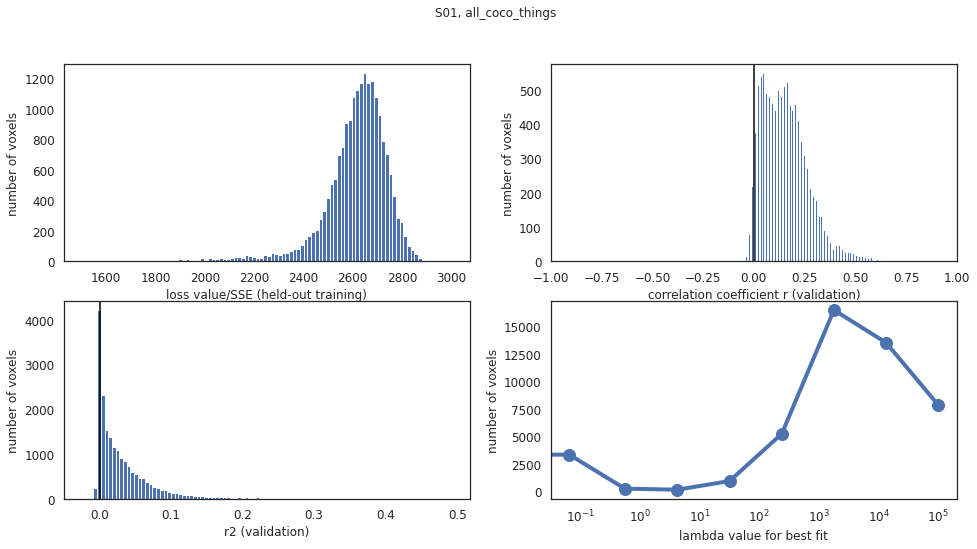

In [16]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_types[0], outlist[0], fig_save_folder=fig_save_folder)

In [17]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_types[1], outlist[1], fig_save_folder=fig_save_folder)

IndexError: list index out of range

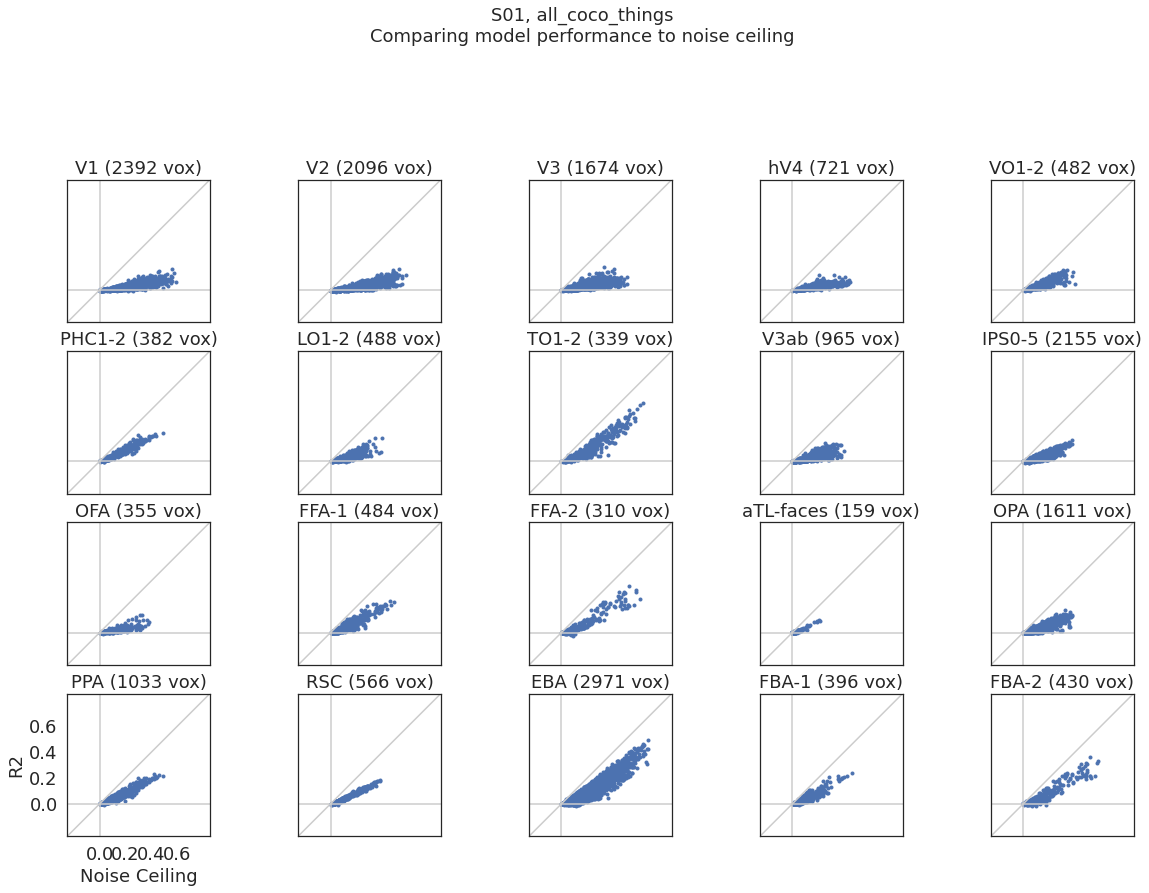

In [18]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_types[0],outlist[0], roi_def=roi_def, skip_inds=skip_inds, \
                            axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, fig_size=(20,24))

In [19]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_types[1],outlist[1], roi_def=roi_def, skip_inds=skip_inds, \
                            axlims = [-0.25, 0.85], fig_save_folder=fig_save_folder, fig_size=(20,24))

IndexError: list index out of range

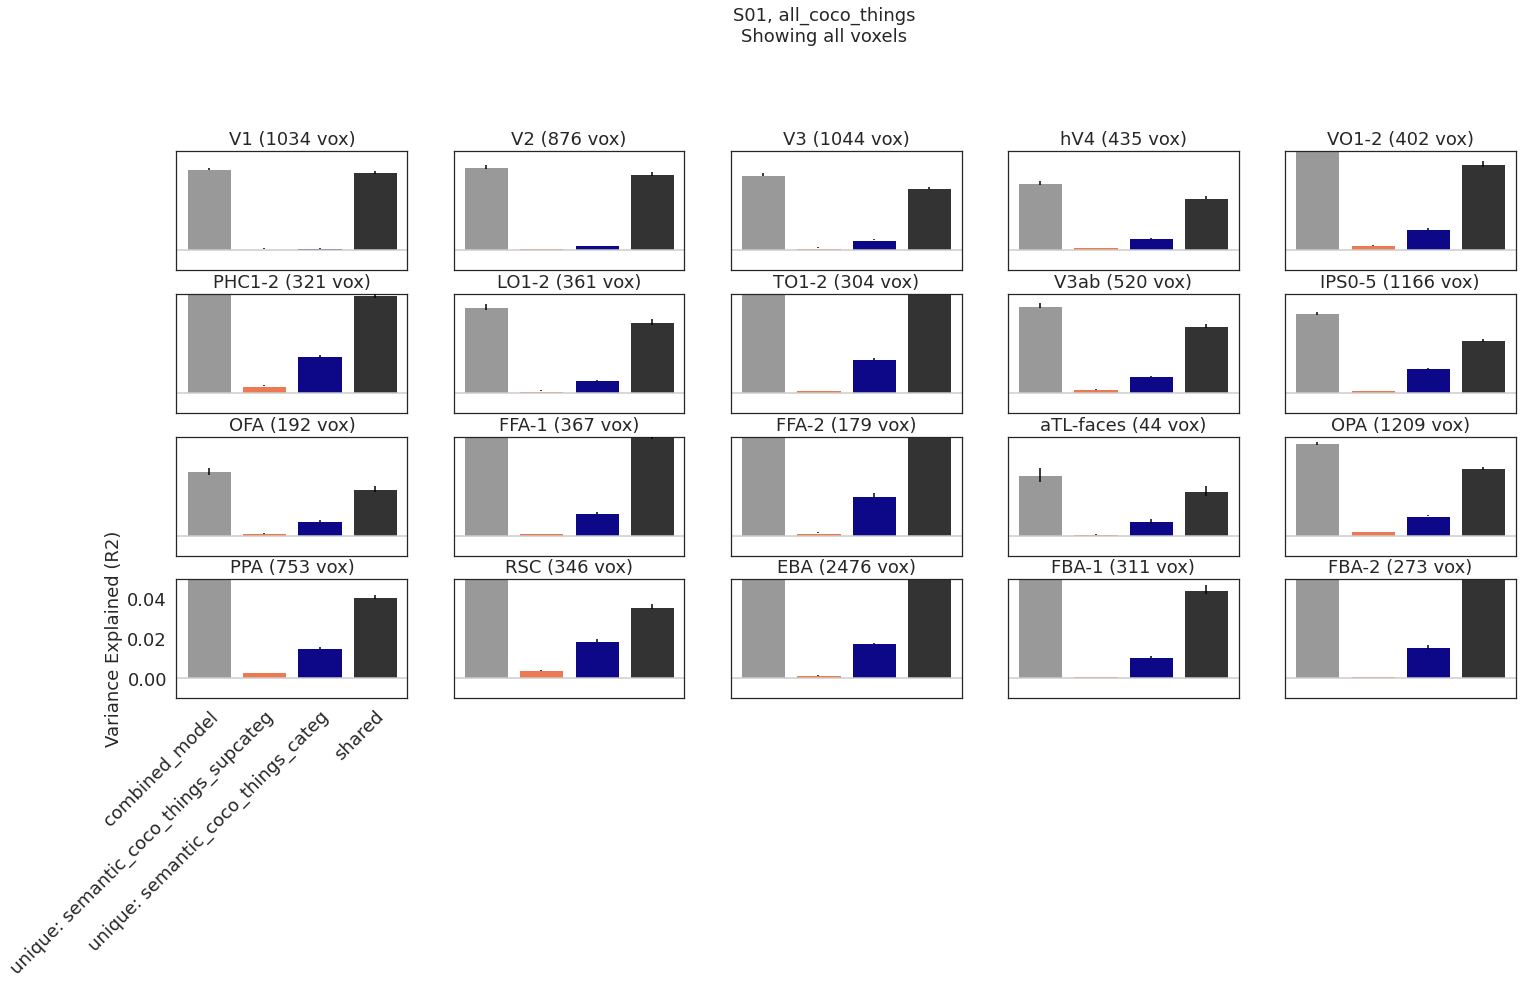

In [22]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.05])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, \
                               skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_eachroi.png'))

In [6]:
# Make plots in pycortex 

import cortex

port=63333

vox2plot = outlist[0]['val_r2'][:,0]>-100

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(outlist[0]);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]

maps += [np.sqrt(outlist[ii]['val_r2'][:,0]) for ii in range(len(outlist))]
names += ['%s R2 (sqrt)'%fitting_types[ii] for ii in range(len(outlist))]
cmaps += ['PuBu' for ii in range(len(outlist))]
mins += [0 for ii in range(len(outlist))]
maxes += [0.6 for ii in range(len(outlist))]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


Data is in 3d volume space
navigate browser to: 127.0.0.1:63333
Started server on port 63333


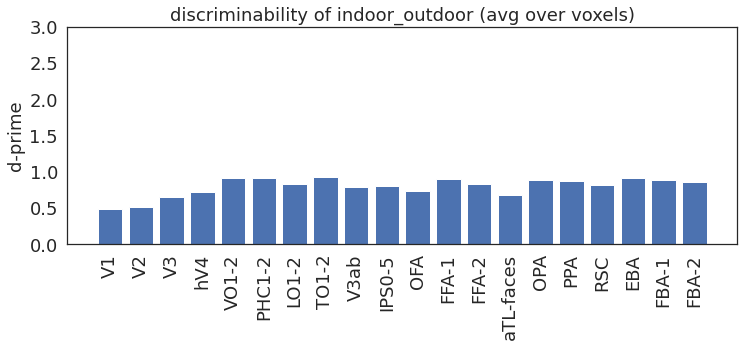

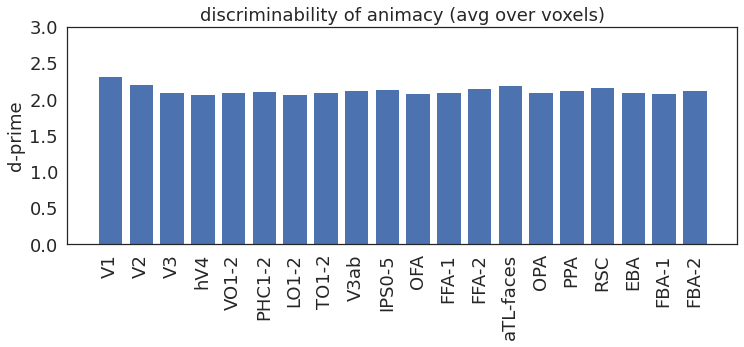

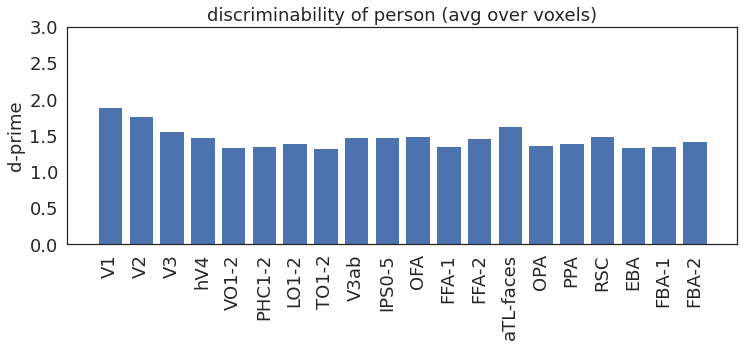

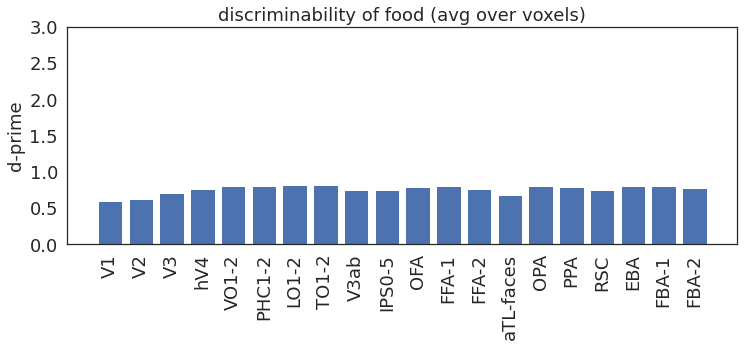

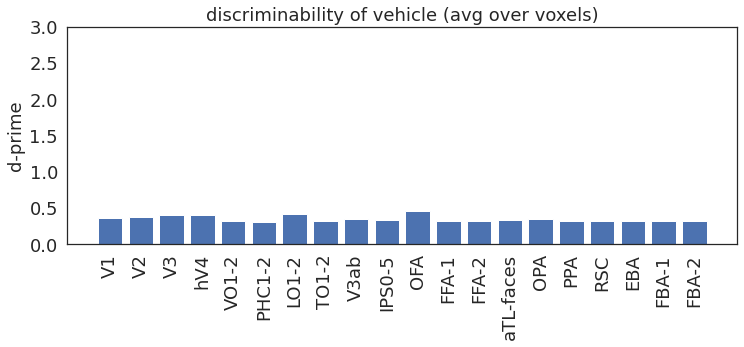

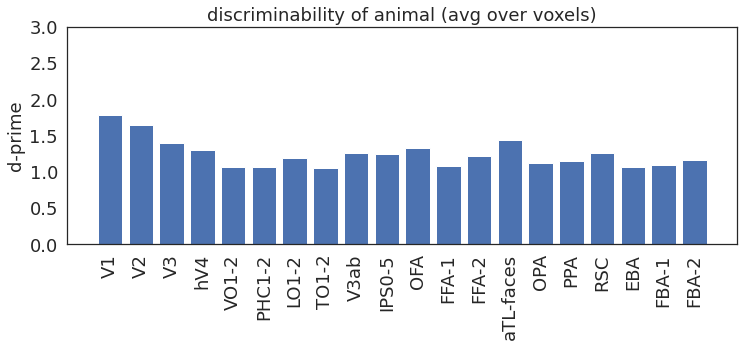

In [15]:
out = outlist[0]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan


for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,3.0])

In [28]:
# Make plots in pycortex 

out = outlist[0]

import cortex

port=43333

vox2plot = out['val_r2'][:,0]>-100

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['semantic model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

wts = out['best_params'][1]
maps += [wts[:,0,0]]
names += ['semantic feature weight']
cmaps += ['PuBu']
mins += [-0.6]
maxes += [0.6]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]



plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:43333
Started server on port 43333


In [28]:
# Make plots in pycortex 

out = outlist[0]

import cortex

port=43333

vox2plot = out['val_r2'][:,0]>-100

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['semantic model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

wts = out['best_params'][1]
maps += [wts[:,0,0]]
names += ['semantic feature weight']
cmaps += ['PuBu']
mins += [-0.6]
maxes += [0.6]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]



plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:43333
Started server on port 43333
